In [2]:
import os
import pickle
import numpy as np
import yaml
import random
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from hmc_uq.utils.evaluation import HMCSampleEvaluation
from scipy.signal import correlate

In [2]:
target = 'CYP'
target_id = 1908
nr_eval_params = 10000
init = 'bbb'
nr_samples = 10000
nr_chains = 5
step_size = 0.0013
l = 1000


In [4]:
ckpt_path = 'configs/ckpt_paths/HMC.yaml'
with open(ckpt_path) as f:
    ckpt_paths = yaml.load(f, Loader=yaml.FullLoader)[f'{init}init']

models_config = 'configs/models/HMC.yaml'
with open(models_config) as f:
    models_configs = yaml.load(f, Loader=yaml.FullLoader)   

In [4]:
target_info = models_configs[target]
#hidden_sizes = target_info['hidden_sizes']
hidden_sizes = 4
nr_layers = 1
#nr_layers = target_info['nr_layers']
#l = target_info['L']
#step_size = target_info['step_size']

parameter_sizes = [4096 * hidden_sizes, hidden_sizes]
for layer in range(nr_layers - 1):
    parameter_sizes.append(hidden_sizes * hidden_sizes, hidden_sizes)
parameter_sizes.extend([hidden_sizes, 1])


param_names = []
for i in range(nr_layers + 1):
    for t in ['weight', 'bias']:
        param_names.append(f'{t}.{i}')

In [75]:
np.load('/data/leuven/356/vsc35684/git/HMC-UQ/results/mass_matrix/mm.npy')

array([  47.864265,   44.851948,   55.93615 , ..., 3247.4346  ,
       3180.6638  , 2683.8833  ], dtype=float32)

# Load raw Data

In [62]:
def filter_params_raw(nr_eval_params, ckpt_paths, parameter_sizes, return_layer = False):
    params_filtered = []
    for path in ckpt_paths:
        params = np.load(f'{ckpt_paths[path]}.npy')
        assert params.shape[-1] == np.sum(parameter_sizes)
        
        nr_params_rest = np.sum(parameter_sizes[1:])
        nr_params_first = nr_eval_params - nr_params_rest
        nr_params_first = 0 if nr_params_first <= 0 else nr_params_first
        if nr_params_first <= 10:
            print(f'{nr_params_first} Parameters of first Layer plotted!')

        parameter_sizes_reduced = parameter_sizes.copy()
        parameter_sizes_reduced[0] = nr_params_first
        first_samples = random.sample(list(range(nr_params_first)), nr_params_first)
        params_first = params[:, :, first_samples]
        print(params_first.shape)
        params_rest = params[:, :, -nr_params_rest:]
        print(params_rest.shape)
        params_eval = np.concatenate((params_first, params_rest), axis = 2)
        print(params_eval.shape)
        params_filtered.append(params_eval)
    params_filtered = np.concatenate(params_filtered, axis = 0)

    if return_layer:
        cumsum = np.cumsum(parameter_sizes_reduced)[:-1]
        params_filtered = np.array_split(params_filtered, cumsum, axis = 2)
        return params_filtered
    else:
        return params_filtered
    

In [63]:
params_reduced= filter_params_raw(nr_eval_params, ckpt_paths, parameter_sizes, return_layer=True)

(1, 1001, 9991)
(1, 1001, 9)
(1, 1001, 10000)
(1, 1001, 9991)
(1, 1001, 9)
(1, 1001, 10000)


In [64]:
params_reduced[0].shape

(2, 1001, 9991)

In [65]:
nr_chains, nr_samples, _= params_reduced[0].shape

In [66]:
file_name = f'results/models/HMC/reduced/{target_id}_e{step_size}_l{l}_nrs{nr_samples}_nrc{nr_chains}_{init}init_mm{mm}_reducedparam{nr_eval_params}'
with open(file_name, 'wb') as f:
    pickle.dump(params_reduced, f)


# Load and filter reduced data

In [67]:
file_name = f'results/models/HMC/reduced/{target_id}_e{step_size}_l{l}_nrs{nr_samples}_nrc{nr_chains}_{init}init_mm{mm}_reducedparam{nr_eval_params}'

with open(file_name, 'rb') as f:
    params_reduced = pickle.load(f)

print(file_name)

results/models/HMC/reduced/1908_e0.00013_l1_nrs1001_nrc2_randominit_mmTrue_reducedparam10000


In [68]:
def filter_params_reduced(params, nr_eval_params, return_layer = False):
    parameter_sizes = []
    for layer in params:
        parameter_sizes.append(layer.shape[2])
    nr_params_rest = np.sum(parameter_sizes[1:])
    nr_params_first = nr_eval_params - nr_params_rest
    first_layer_size = parameter_sizes[0]

    if nr_eval_params >= np.sum(parameter_sizes):
        params_eval= params.copy()

    else:
        nr_params_first = 0 if first_layer_size < nr_params_first else nr_params_first
        if nr_params_first <= 10:
            print(f'{nr_params_first} Parameteres of first Layer plotted!')

        first_samples = random.sample(list(range(first_layer_size)), nr_params_first)

        params_eval = params.copy()
        params_eval[0] = params_eval[0][:, :, first_samples]    
    if return_layer:
        return params_eval
    else:
        params_eval = np.concatenate(params_eval, axis = 2)
        return params_eval

# Check Autocorrelation

In [69]:
params_eval = filter_params_reduced(params_reduced, 20, return_layer=True)

### 1. Mean over Chains

In [8]:
sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
sample_eval.calculate_autocorrelation()

nr_samples_params = 50

<Axes: xlabel='LAG', ylabel='AUTOCORR'>

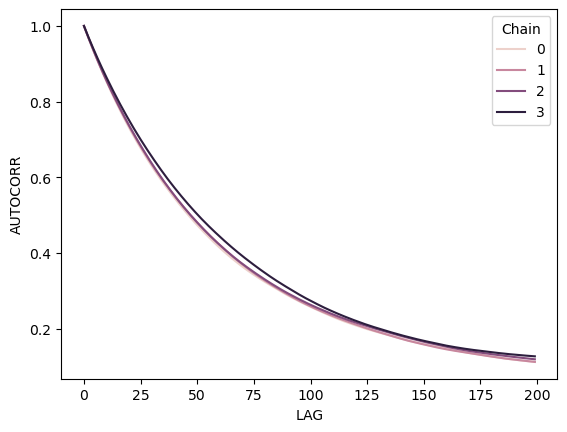

In [36]:
sample_eval.autocorrelation_plot()

### 2. Plot Single Parameters (per Chain)

In [70]:
from matplotlib.lines import Line2D

def autocorrelation_singleparam(params_eval):
    max_lag = 7000
    #to get normalized correlation
    params_chain_a = (params_eval- np.mean(params_eval)) / (np.std(params_eval) * len(params_eval))
    params_chain_b = (params_eval - np.mean(params_eval)) / np.std(params_eval)
    ac_param = correlate(params_chain_a, params_chain_b)
    half_idx = len(ac_param)//2
    ac_param = ac_param[half_idx:(half_idx + max_lag)]
    return ac_param

colors = sns.color_palette('colorblind').as_hex()
layer_names = []
for l in range(nr_layers + 1):
    layer_names.append(r'$W^{' + str(l+1) + r'}$')
    layer_names.append(r'$b^{' + str(l+1) + r'}$')


def calculate_autocorrelation(params_chains):
    AC = {'Burn-in' : [], 'Chain':[], 'LAG' : [],'#Burn-in': [], 'AUTOCORR': []}
    for chain in range(nr_chains):
        for param_type in range(4):
            params_chain= params_chains[param_type][chain]

            ac = np.apply_along_axis(autocorrelation_singleparam, arr = params_chain, axis = 0)
            if param_type == 0:
                fig, axs = plt.subplots()
                custom_lines = []
                labels = []
            for param in range(ac.shape[1]):
                df = pd.DataFrame(ac[:,param], columns = ['Samples'])
                ax = sns.lineplot(data = df, x = df.index, y = 'Samples', legend = False, color = colors[param_type])
                ax.set_title(f'Chain {chain + 1}')
                ax.set(xlabel='Lag', ylabel='Autocorrelation')
            custom_lines.append(Line2D([0], [0], color= colors[param_type], lw=2))
            labels.append(f'{layer_names[param_type]}')
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
        sns.despine()


        ax.legend(custom_lines, labels)
                

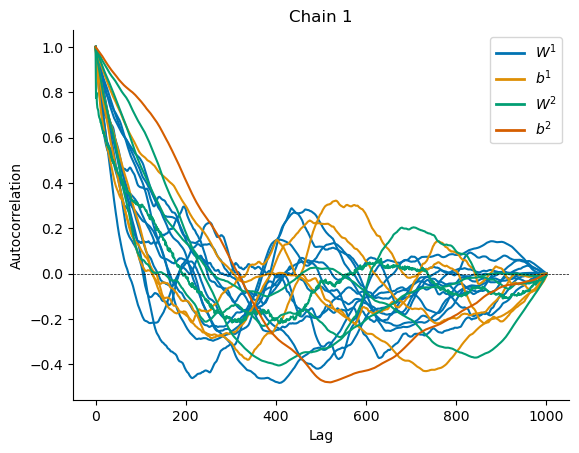

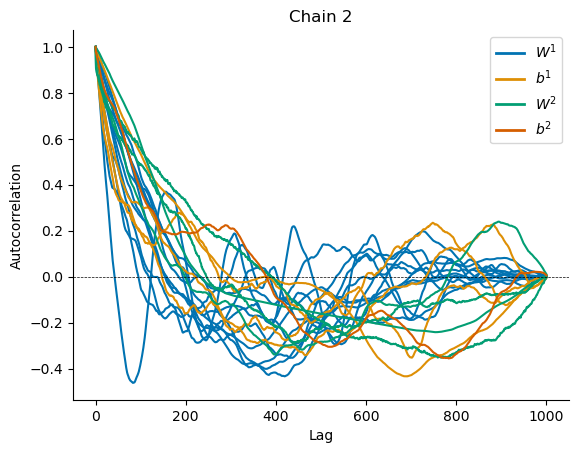

In [71]:
calculate_autocorrelation(params_eval)

### 3. Plot Single Parameters (per Params)

In [51]:
params_eval = filter_params_reduced(params_reduced, 50, return_layer=True)

In [52]:
def autocorrelation_singleparam(params_eval):
    max_lag = 20000
    #to get normalized correlation
    params_chain_a = (params_eval- np.mean(params_eval)) / (np.std(params_eval) * len(params_eval))
    params_chain_b = (params_eval - np.mean(params_eval)) / np.std(params_eval)
    ac_param = correlate(params_chain_a, params_chain_b)
    half_idx = len(ac_param)//2
    ac_param = ac_param[half_idx:(half_idx + max_lag)]
    return ac_param


layer_names = []

for l in range(nr_layers + 1):
    layer_names.append(r'$W^{' + str(l+1) + r'}$')
    layer_names.append(r'$b^{' + str(l+1) + r'}$')

    
def calculate_autocorrelation(params_layer):
    AC = {'Burn-in' : [], 'Chain':[], 'LAG' : [],'#Burn-in': [], 'AUTOCORR': []}

    for i,layer in enumerate(params_layer):
        layer = layer.reshape(nr_chains * nr_samples, -1)

        ac = np.apply_along_axis(autocorrelation_singleparam, arr = layer, axis = 0)
        fig, axs = plt.subplots()
        for param in range(ac.shape[1]):
            df = pd.DataFrame(ac[:,param], columns = ['Samples'])
            ax = sns.lineplot(data = df, x = df.index, y = 'Samples', legend = False)
            ax.set_title(f'Parameter: {layer_names[i]}')
        ax.set(xlabel='Lag', ylabel='Autocorrelation')
        ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
        sns.despine()

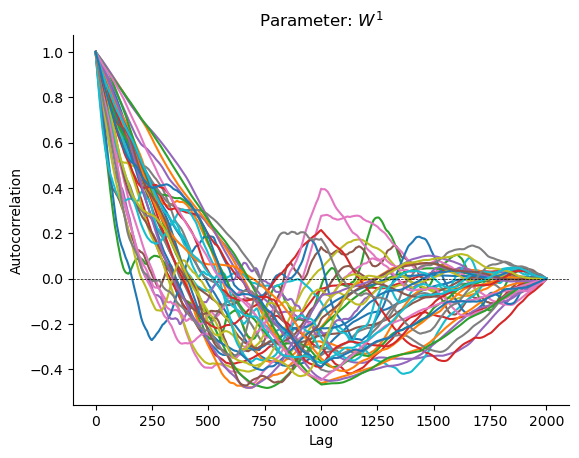

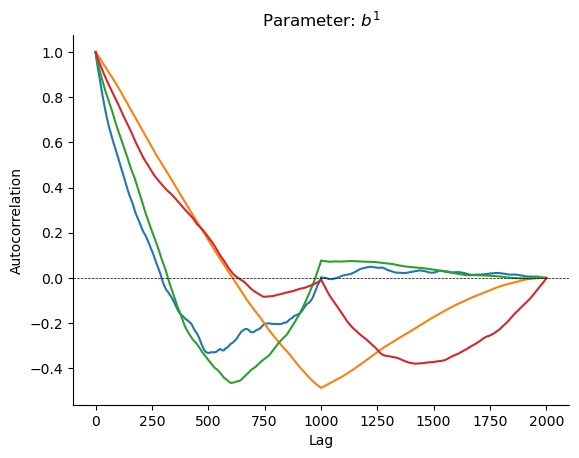

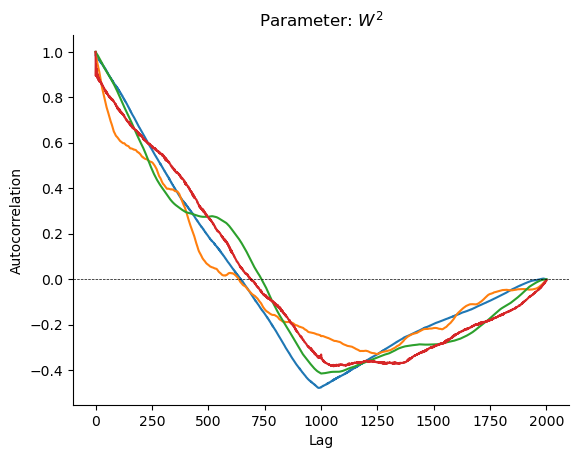

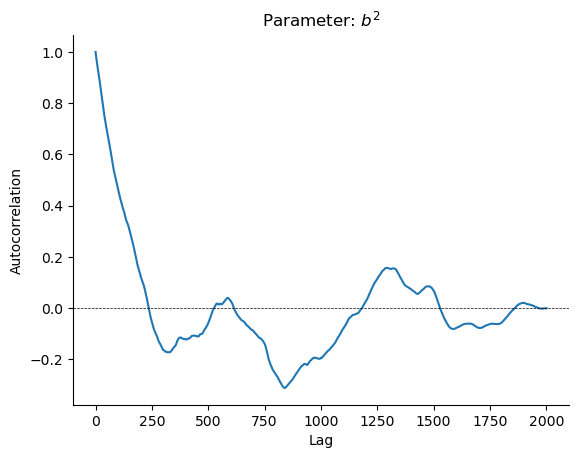

In [53]:
calculate_autocorrelation(params_eval)

# Trace Plot

In [72]:
params_eval = filter_params_reduced(params_reduced, 30, return_layer=True)

In [73]:
layer_names = []

for l in range(nr_layers + 1):
    layer_names.append(r'$W^{' + str(l+1) + r'}$')
    layer_names.append(r'$b^{' + str(l+1) + r'}$')

colors = sns.color_palette('colorblind').as_hex()

def trace_plot(params, nr_plotsamples):
    fig, axs = plt.subplots(ncols = 1, nrows=len(params), figsize = (10,20))      
    nr_chains = len(params[0]) 
    
    for idx_param, params_layer in enumerate(params):
        params_filtered = pd.DataFrame({})
        nr_params_layer= params_layer.shape[2]
        for chain in range(nr_chains):
            params_layer_chain = pd.DataFrame(params_layer[chain], columns = [f'Param{i}' for i in range(nr_params_layer)])
            params_layer_chain = params_layer_chain.iloc[:nr_plotsamples]
            params_layer_chain['Sample'] = range(len(params_layer_chain))
            params_layer_chain_long = params_layer_chain.melt(id_vars = 'Sample', var_name = 'Param', value_name = 'Value')
            params_layer_chain_long['Chain'] = chain + 1
            params_filtered = pd.concat((params_filtered, params_layer_chain_long))

        for param in set(params_filtered['Param']):
            params_filtered_singleparam = params_filtered[params_filtered['Param'] == param] 
            if param == 'Param0':
                ax = sns.lineplot(data = params_filtered_singleparam, x = 'Sample', y = 'Value', legend = True, hue = 'Chain', ax = axs[idx_param], palette='colorblind')

            else:               
                ax = sns.lineplot(data = params_filtered_singleparam, x = 'Sample', y = 'Value', legend = False, hue = 'Chain', ax = axs[idx_param], palette='colorblind')
        ax.set_title(layer_names[idx_param])
        ax.set_xlabel('')
        sns.despine()
    plt.tight_layout()
    plt.show()

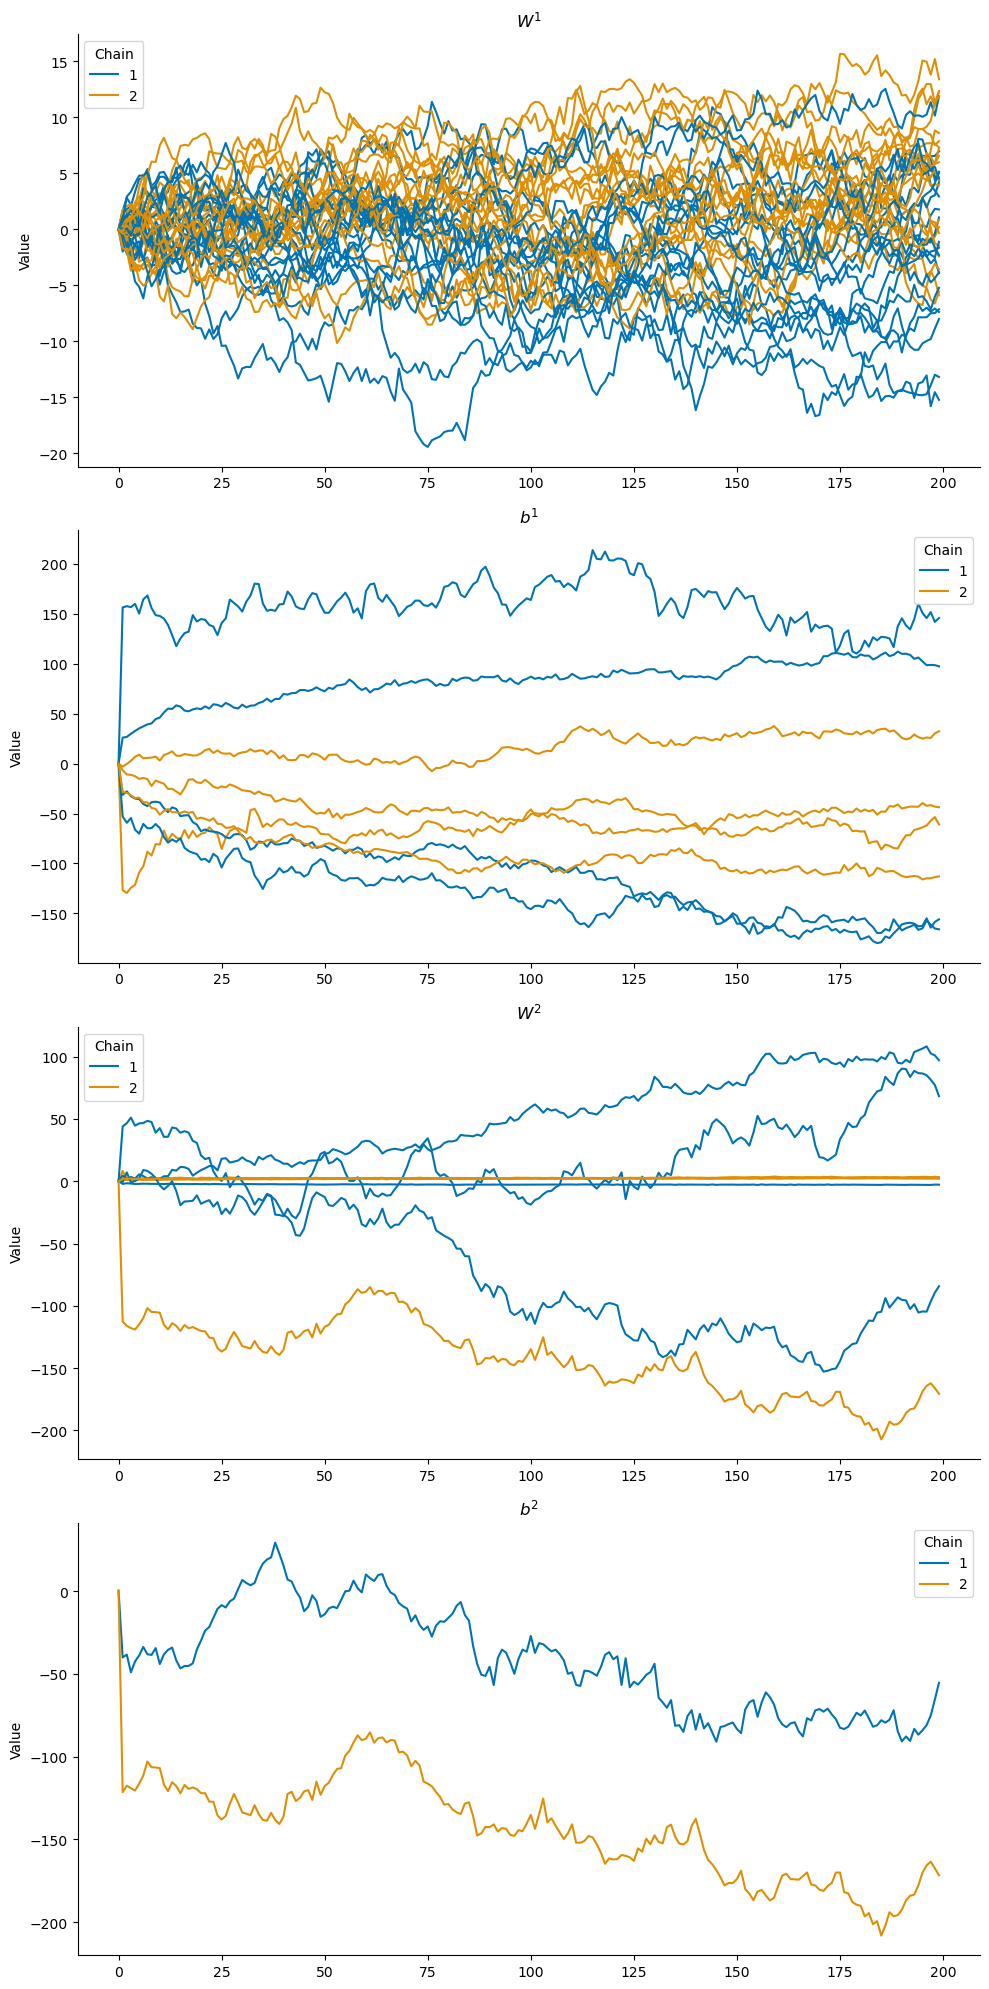

In [74]:
trace_plot(params_eval, 200)

### Trace plots colored by chains

In [37]:
params_eval = filter_params_reduced(params_reduced, 1000, return_layer=True)

In [38]:
params_showed = len(params_eval)

def trace_plot(params, nr_plotsamples, params_layer, plot_idx):
    #params_layer = from which param do I want to plot?
    #plot_idx = index from param I want to plot
    one_params = params_eval[params_layer][:,:,plot_idx].T
    one_params  = pd.DataFrame(one_params, columns = ['Chain 1', 'Chain 2', 'Chain 3', 'Chain 4'])
    for chain in range(4):
        now = one_params[f'Chain {chain + 1}'][:nr_plotsamples]
        sns.lineplot(data = now)


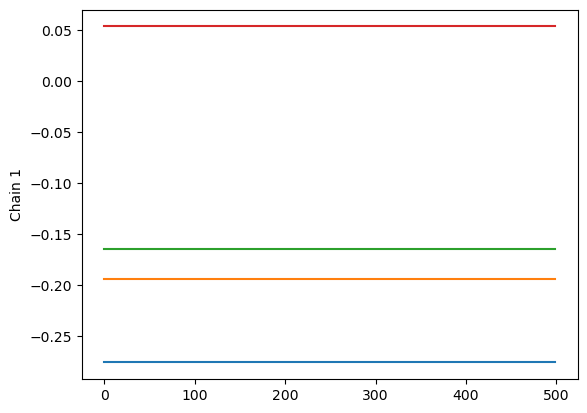

In [39]:
trace_plot(params_eval, 500, 2, 0)

# RHAT

In [46]:
# All parameters

params_eval = filter_params_reduced(params_reduced, 200, return_layer=False)

sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
rhat = sample_eval.split_rhat(burnin = 0)
rhat_rn = sample_eval.split_rhat(burnin = 0, rank_normalized = True)

print(f'Parameter: Across all Parameters')
print(f'Split-RHAT:')
print(f'{np.mean(rhat)} +/- {np.std(rhat)}')
print(f'RN-Split-RHAT:' )
print(f'{np.mean(rhat_rn)} +/- {np.std(rhat_rn)}')

Parameter: Across all Parameters
Split-RHAT:
1.1150996685028076 +/- 0.39577600359916687
RN-Split-RHAT:
1.0831352647802956 +/- 0.24257460019525914


In [47]:
# for every layer

params_eval = filter_params_reduced(params_reduced, 200, return_layer=True)

for burnin in range(0, 5000, 500):
    print('==============')
    print(f'Burnin {burnin}')
    for idx, params in enumerate(params_eval):
        sample_eval = HMCSampleEvaluation(params, 4096, hidden_sizes, reduce = False)
        rhat = sample_eval.split_rhat(burnin = burnin)
        rhat_rn = sample_eval.split_rhat(burnin = burnin, rank_normalized = True)


        print(f'Parameter: {param_names[idx]}')
        print(f'Split-RHAT:')
        print(f'{np.mean(rhat)} +/- {np.std(rhat)}')
        print(f'RN-Split-RHAT:' )
        print(f'{np.mean(rhat_rn)} +/- {np.std(rhat_rn)}')

Burnin 0
Parameter: weight.0
Split-RHAT:
1.0340197086334229 +/- 0.025365009903907776
RN-Split-RHAT:
1.0338528779567213 +/- 0.025160917213366097
Parameter: bias.0
Split-RHAT:
3.1934499740600586 +/- 0.3528537154197693
RN-Split-RHAT:
2.1357416530846023 +/- 0.2919317120631324
Parameter: weight.1
Split-RHAT:
2.6114232540130615 +/- 0.4506620466709137
RN-Split-RHAT:
2.1428213807070753 +/- 0.23345109040432457
Parameter: bias.1
Split-RHAT:
2.647897481918335 +/- 0.0
RN-Split-RHAT:
2.3747225841750566 +/- 0.0
Burnin 500


Parameter: weight.0
Split-RHAT:
1.0356568098068237 +/- 0.027679234743118286
RN-Split-RHAT:
1.0354740116906782 +/- 0.02744342053655672
Parameter: bias.0
Split-RHAT:
3.5774128437042236 +/- 0.5540680885314941
RN-Split-RHAT:
2.181722741603732 +/- 0.2898923781166043
Parameter: weight.1
Split-RHAT:
2.7875783443450928 +/- 0.5269930362701416
RN-Split-RHAT:
2.2304323273576534 +/- 0.22242151407209526
Parameter: bias.1
Split-RHAT:
2.784153938293457 +/- 0.0
RN-Split-RHAT:
2.366692132969418 +/- 0.0
Burnin 1000
Parameter: weight.0
Split-RHAT:
1.0377280712127686 +/- 0.028332287445664406
RN-Split-RHAT:
1.0375310779123683 +/- 0.02809204258280495
Parameter: bias.0
Split-RHAT:
3.805875062942505 +/- 0.681193470954895
RN-Split-RHAT:
2.2352869297939817 +/- 0.2535028252296976
Parameter: weight.1
Split-RHAT:
2.951571464538574 +/- 0.6007778644561768
RN-Split-RHAT:
2.2902701982779226 +/- 0.22548456280438472
Parameter: bias.1
Split-RHAT:
2.8124547004699707 +/- 0.0
RN-Split-RHAT:
2.335902517858498 +/- 0.0
Burnin 

# ESS

In [61]:
# All parameters

params_eval = filter_params_reduced(params_reduced, 200, return_layer=False)

sample_eval = HMCSampleEvaluation(params_eval, 4096, hidden_sizes, reduce = False)
sample_eval.calculate_autocorrelation()
ips = sample_eval.ips_per_chain(burnin = 0)
print(ips)


AttributeError: 'HMCSampleEvaluation' object has no attribute 'ips_per_chain'

# Mass Matrix

In [46]:
ckpt_path = 'configs/ckpt_paths/HMC.yaml'
with open(ckpt_path) as f:
    ckpt_paths = yaml.load(f, Loader=yaml.FullLoader)[f'{init}init']

models_config = 'configs/models/HMC.yaml'
with open(models_config) as f:
    models_configs = yaml.load(f, Loader=yaml.FullLoader)   

In [47]:
def find_inv_mm(ckpt_paths, parameter_sizes):
    params_all = []
    for path in ckpt_paths:
        params = np.load(f'{ckpt_paths[path]}.npy')
        assert params.shape[-1] == np.sum(parameter_sizes)
        params_all.append(params)
    params_all = np.concatenate(params_all, axis = 0)
    cumsum = np.cumsum(parameter_sizes)[:-1]
    params_layer = np.array_split(params_all, cumsum, axis = 2)

    inv_mm = []
    for i, params_type in enumerate(params_layer):
        params = params_type.reshape(nr_chains*nr_samples, -1)
        var = params.var(axis = 0)
        if i ==0:
            normalize_const = np.mean(var)
        inv_mm.append(var)
        print(var, np.mean(var), np.max(var), np.min(var))
    
    inv_mm_all = np.concatenate(inv_mm)

    return inv_mm_all

In [48]:
inv_mm_all = find_inv_mm(ckpt_paths, parameter_sizes)

[47.864265 44.851948 55.93615  ... 47.52801  42.118114 47.432144] 49.342567 337.6087 29.850212
[2302.8516 1805.1882 4025.5322 1788.9697] 2480.6355 4025.5322 1788.9697
[ 570.7669 2624.478  3247.4346 3180.6638] 2405.836 3247.4346 570.7669
[2683.8833] 2683.8833 2683.8833 2683.8833


In [49]:
print(inv_mm_all)

[  47.864265   44.851948   55.93615  ... 3247.4346   3180.6638
 2683.8833  ]


In [50]:
np.save('results/mass_matrix/1908_e0.0013_l1000_nrs10000_nrc1_randominit.npy', inv_mm_all)

Devide everything by the mean of variance of the first layer to keep ratios